In [1]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel Bühler for this suggestion


In [3]:
TRAIN_DIR = 'data/dogbreed/train/'
TEST_DIR = 'data/dogbreed/test/'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogs_breed-{}-{}.model'.format(LR, '2conv-basic') # just so we remember which saved model is which, sizes must match

In [7]:
import pandas as pd
label = pd.read_csv('data/dogbreed/labels.csv/labels.csv')

In [8]:
label.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


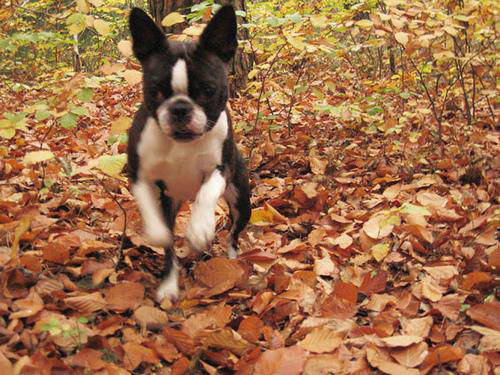

In [21]:
from PIL import Image
Image.open(TRAIN_DIR + "000bec180eb18c7604dcecc8fe0dba07.jpg")

In [24]:
n = len(label)
breed = set(label['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))


In [68]:
width = 299
X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)
for i in tqdm(range(n)):
    X[i] = cv2.resize(cv2.imread('data/dogbreed/train/%s.jpg' % label['id'][i]), (width, width)).astype(int)
    y[i][class_to_num[label['breed'][i]]] = 1

100%|██████████| 10222/10222 [00:28<00:00, 356.71it/s]


In [61]:
X[0]

array([[[ 19,  67, 127],
        [ 69, 119, 178],
        [ 54, 106, 158],
        ..., 
        [ 65, 170, 197],
        [ 67, 143, 175],
        [ 95, 171, 202]],

       [[ 61, 106, 161],
        [ 66, 112, 165],
        [ 48,  95, 144],
        ..., 
        [ 84, 187, 215],
        [ 65, 148, 180],
        [ 74, 157, 189]],

       [[ 52,  92, 141],
        [ 65, 105, 151],
        [ 59, 101, 143],
        ..., 
        [106, 205, 236],
        [ 84, 176, 208],
        [ 79, 170, 204]],

       ..., 
       [[ 69, 121, 189],
        [ 63, 117, 184],
        [ 67, 119, 185],
        ..., 
        [109, 158, 212],
        [112, 165, 218],
        [108, 160, 213]],

       [[ 66, 119, 186],
        [ 63, 116, 183],
        [ 68, 120, 186],
        ..., 
        [ 80, 128, 186],
        [ 95, 151, 203],
        [ 96, 150, 203]],

       [[ 62, 115, 182],
        [ 63, 116, 183],
        [ 69, 122, 188],
        ..., 
        [ 64, 110, 171],
        [ 76, 133, 186],
        [ 83, 140,

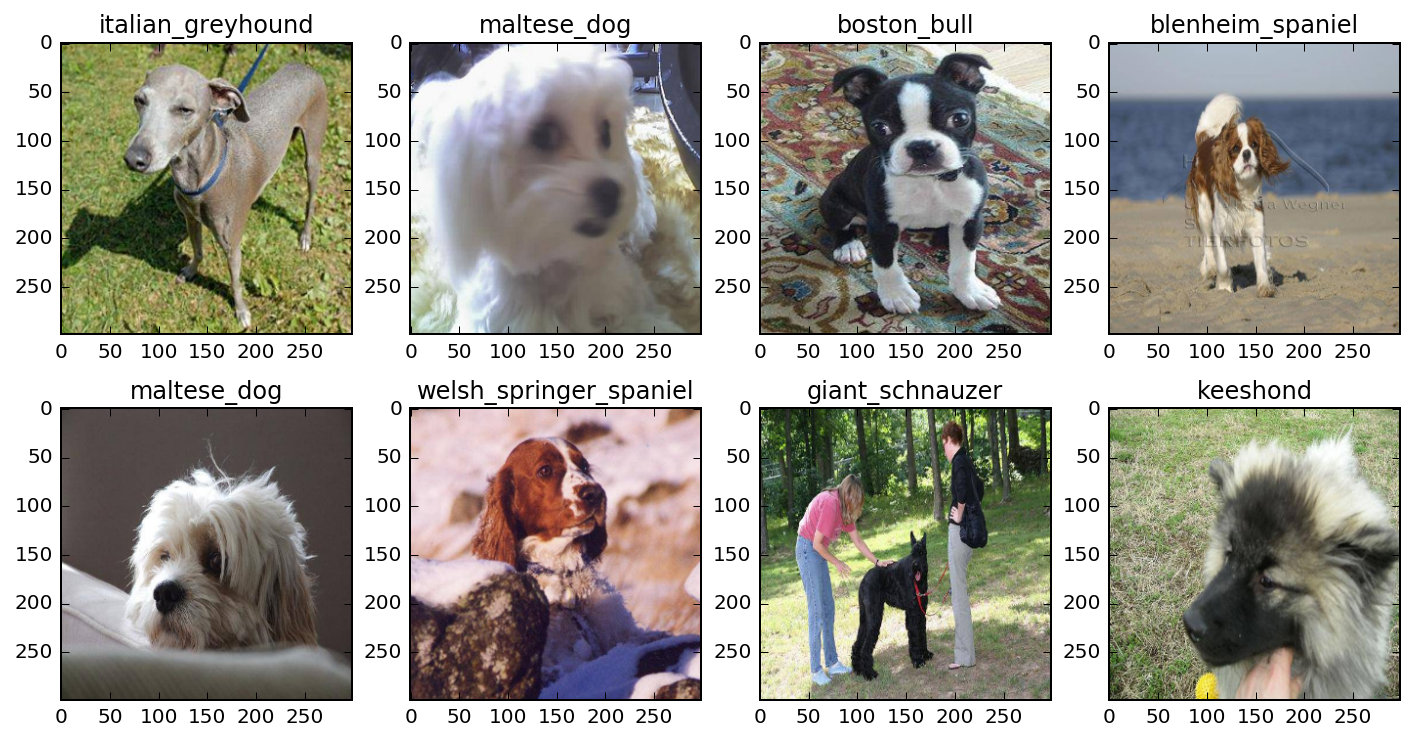

In [62]:
import random
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12, 6))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(num_to_class[y[random_index].argmax()])

In [63]:
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input

In [64]:
def get_features(MODEL, data=X):
    cnn_model = MODEL(include_top=False,  input_shape=(width, width, 3),weights='imagenet')
    
    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=64, verbose=1)
    return features

In [65]:
inception_features = get_features(InceptionV3, X)
xception_features = get_features(Xception, X)
features = np.concatenate([inception_features, xception_features], axis=-1)

TypeError: Expected int32, got list containing Tensors of type '_Message' instead.

In [54]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax')(x)
model = Model(inputs, x)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
h = model.fit(features, y, batch_size=128, epochs=10, validation_split=0.1)

NameError: name 'features' is not defined